# Exploratory work for JOW
## based on the Facebook Insights on the posts from 01/01/2019 up to 11/02/2020
 

In [1]:
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
import random 
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(6,4)})

directory = "C:/Users/lfiorentini/TequilaRapido/JOW/Data/FB"
directory_img = "C:/Users/lfiorentini/TequilaRapido/JOW/Data/FB/img"
directory_csv = "C:/Users/lfiorentini/TequilaRapido/JOW/Data/FB/csv"
file1 = "Jan_May_19.csv"
file2 = "Jun_Oct_19.csv"
file3 = "Nov_Feb_20.csv"
feat_str = 8

## Definition of keywords and function to count them
we will work only with lowercase strings

In [2]:
keywords_set_1 = ['electric', 'environment', 'sustainable', 'hybrid', 'co2']
keywords_set_2 = ['mobility', 'share', 'co2', 'safety']
keywords_set_3 = ['city', 'smart', 'co2', 'safety']

# Car enthousiasts
#keywords_set_4 = ['zoe', 'koleos', 'twingo', 'kangoo', 'ez-pro']
keywords_set_4 = ['safe', 'maintenance', 'car service', 'car service', 'car service', ]

def count_key_message(Message, key_set):
    res = 0
    for word in key_set:
        if word in Message:
            res += 1
    return res

## Upload data and concatenate different files
* remove line 1 which is the description of the header
* remove features with only NaN in one file
* remove rows with only NaN for each file
* reduce to common headers to all the files

In [3]:
headers = pd.read_csv(os.path.join(directory, file1), header=0, nrows = 1)#, converters = conver_dict)
type_dict = {}
for i in range(len(headers.columns)):
    if i < feat_str: 
        type_dict[headers.columns[i]] = str
    else:
        type_dict[headers.columns[i]] = np.float64 #we need float to deal with all the NaN
Data1 = pd.read_csv(os.path.join(directory, file1), header=0, skiprows = [1], dtype = type_dict)
Data2 = pd.read_csv(os.path.join(directory, file2), header=0, skiprows = [1], dtype = type_dict)
Data3 = pd.read_csv(os.path.join(directory, file3), header=0, skiprows = [1], dtype = type_dict)

Data1.dropna(axis = 1, how='all', inplace=True)
Data2.dropna(axis = 1, how='all', inplace=True)
Data3.dropna(axis = 1, how='all', inplace=True)

#print(len(Data1.columns))
#print(len(Data2.columns))
#print(len(Data3.columns))

common_head = list(set(Data1.columns) & set(Data2.columns) & set(Data3.columns))
len(common_head)

def remove_not_common(Data, common):
    for i in Data.columns:
        if i not in common_head:
            Data.drop(i, axis = 1, inplace = True)

remove_not_common(Data1, common_head)
remove_not_common(Data2, common_head)
remove_not_common(Data3, common_head)

#print(len(Data1.columns))
#print(len(Data2.columns))
#print(len(Data3.columns))

Data_f = pd.concat([Data1, Data2, Data3], sort=True)
Data_f.reset_index(drop = True, inplace = True)
Data_f.head()

,Audience targeting,Lifetime Average time video viewed,Lifetime Engaged Users,Lifetime Matched Audience Targeting Consumers on Post,Lifetime Matched Audience Targeting Consumptions by Type - link clicks,Lifetime Matched Audience Targeting Consumptions by Type - other clicks,Lifetime Matched Audience Targeting Consumptions by Type - photo view,Lifetime Matched Audience Targeting Consumptions by Type - video play,Lifetime Matched Audience Targeting Consumptions on Post,Lifetime Negative Feedback,...,Lifetime Post reach by people who like your Page,Lifetime Talking About This (Post) by action type - comment,Lifetime Talking About This (Post) by action type - like,Lifetime Talking About This (Post) by action type - share,Lifetime Video length,Permalink,Post ID,Post Message,Posted,Type
0,,0.0,158.0,113.0,6.0,108.0,9.0,NaN,123.0,0.0,...,2025.0,20.0,48.0,NaN,0.0,https://www.facebook.com/jowradio/posts/261933...,110764313093221_261933241309660,واش رايكم في قائمة الخضر المعنية بكأس امم إفري...,05/30/2019 11:05:07 AM,Photo
1,,0.0,323.0,228.0,22.0,229.0,38.0,NaN,289.0,3.0,...,5691.0,18.0,120.0,2.0,0.0,https://www.facebook.com/jowradio/posts/261930...,110764313093221_261930774643240,اليوم رايحا تتروبل في استوديو بالون لأن أنصار ...,05/30/2019 11:00:46 AM,Photo
2,,0.0,52.0,32.0,1.0,28.0,6.0,NaN,35.0,1.0,...,1166.0,1.0,22.0,NaN,0.0,https://www.facebook.com/jowradio/posts/261929...,110764313093221_261929677976683,ضيفنا اليوم في بالون هو اللاعب الدولي الجزائري...,05/30/2019 11:00:25 AM,Photo
3,,15649.0,502.0,466.0,NaN,400.0,NaN,243.0,644.0,0.0,...,5336.0,8.0,54.0,4.0,121662.0,https://www.facebook.com/jowradio/posts/261638...,110764313093221_261638561339128,دانيا إيدير طفلة صغيرة لكن عندها كثر من 300 أ...,05/30/2019 10:20:00 AM,Video
4,,9940.0,422.0,385.0,NaN,258.0,NaN,234.0,493.0,0.0,...,3900.0,10.0,42.0,3.0,47785.0,https://www.facebook.com/jowradio/posts/261635...,110764313093221_261635888006062,أصغر مؤثرة على الانستغرام دنيا إيدير : &quot...,05/30/2019 09:30:00 AM,Video


## First step of feature engineering

* remove features with at most one value (no variance no need)
* remove features with more than 25% of NaN value
* drop the publication ID and link
* transform the message to lowercase
* remove 'lifetime' from the feature name 
* remove rows with still some NaN
* remove rows corresponding to status or to a link (they are either errors or irrelevant)


In [4]:
Data_f.fillna(value = 0, inplace = True)
list_useless = []
for col_name in Data_f.columns:
    if len(Data_f[col_name].unique()) <= 1:
        list_useless.append(col_name)
Data_f.drop(list_useless, axis=1, inplace=True)

Data_comment = Data_f['Post Message'].copy()

Data_f.drop(['Post ID','Permalink'], axis=1, inplace=True)
#Data_f.drop(['Identifiant de la publication','Lien permanent','Publié'], axis=1, inplace=True)

#Data_f['Message de publication'] = Data_f['Message de publication'].str.lower()
Data_f['Post Message'] = Data_f['Post Message'].str.lower()
    
tmp = Data_f.columns.copy()
tmp = [x.replace("Lifetime ","") for x in tmp]
Data_f.columns = tmp

Data_f.dropna(axis = 0, how='any', inplace=True)
print(Data_f['Type'].unique())
Data_f.drop(Data_f[Data_f['Type'] == 'SharedVideo'].index, inplace=True)
Data_f.drop(Data_f[Data_f['Type'] == 0].index, inplace=True)
Data_f.drop(Data_f[Data_f['Type'] == 'Status'].index, inplace=True)
Data_f.drop(Data_f[Data_f['Type'] == 'Link'].index, inplace=True)

['Photo' 'Video' 'Link' 'SharedVideo' 0 'Status']


## Second step on feature engineering: time
* Create timestamp
* Create is_tequila
* Create working_day
* Create moment_day
* Remove Posted


In [5]:
from datetime import datetime

def working_day(date_str):
    try:
        day_code = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')
    except ValueError as e:
        print('StrError:', date_str)
        #print('ValueError:', e)
    day_code = day_code.weekday()
    return day_code != 0 and day_code != 6

def moment_day(date_str):
    hour = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p').hour
    if hour <= 6 or hour >= 23:
        return "Night"
    if hour <= 10 or hour >= 7:
        return "Morning"
    if hour <= 18 or hour >= 11:
        return "Working"
    return "Evening"

def get_timestamp(date_str):
    return datetime.timestamp(datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p'))

Data_f['timestamp'] = Data_f['Posted'].apply(get_timestamp)
Data_f['working_day'] = Data_f['Posted'].apply(working_day)
Data_f['moment_day'] = Data_f['Posted'].apply(moment_day)
Data_f.drop('Posted', axis=1, inplace=True)
Data_f['is_paid'] = Data_f['Post Paid Reach'] > 0
Data_f = pd.get_dummies(Data_f, columns = ['moment_day', 'Type'], drop_first = True)

## Third step of feature engineering
Compute and display correlation matrices for the overall dataset as well as for data divided by post type

In [6]:
Q1 = Data_f[Data_f['Type_Video'] == 1].drop('Type_Video', axis = 1).corr()
#for the photo we have also to remove all the features that make sense only for a video
video_attr_list = ['Type_Video', 'Organic views to 95%', 'Organic views to 95%.1',\
                                                    'Paid views to 95%', 'Paid views to 95%.1',\
                                                    'Organic Video Views', 'Organic Video Views.1',\
                                                    'Paid Video Views', 'Paid Video Views.1',\
                                                    'Organic Video Views', 'Organic Video Views.1',\
                                                    'Average time video viewed', 'Video length']
Q2 = Data_f[Data_f['Type_Video'] == 1].drop(video_attr_list, axis = 1).corr()
Q3 = Data_f.drop('Type_Video', axis = 1).corr()

print(Data_f.shape)
print(Q3.shape) # should have 2 attributes less since there is still the message and the rtype which are str
pict1_html = 'Video_corr.html'
pict2_html = 'Photo_corr.html'
pict3_html = 'Global_corr.html'

Html_file= open(os.path.join(directory_img, pict1_html),"w")
Html_file.write(Q1.style.background_gradient(cmap='coolwarm').render())
Html_file.close

Html_file= open(os.path.join(directory_img, pict2_html),"w")
Html_file.write(Q2.style.background_gradient(cmap='coolwarm').render())
Html_file.close

Html_file= open(os.path.join(directory_img, pict3_html),"w")
Html_file.write(Q3.style.background_gradient(cmap='coolwarm').render())
Html_file.close


(1321, 54)
(52, 52)


C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<function TextIOWrapper.close()>

In [7]:
sns.set(rc={'figure.figsize':(24,12)})

plt.subplot(1,3,1)
sns.heatmap(Q1, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = True)

# we move this one to the right since it's different from the previous ones in terms of dimension
plt.subplot(1,3,3)
sns.heatmap(Q2, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

plt.subplot(1,3,2)
sns.heatmap(Q3, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

plt.savefig(os.path.join(directory_img, "corr_comparison.png"))
plt.close()

## Comparison between organic et paid for Reach and Impression

KeyError: 'Post organic reach'

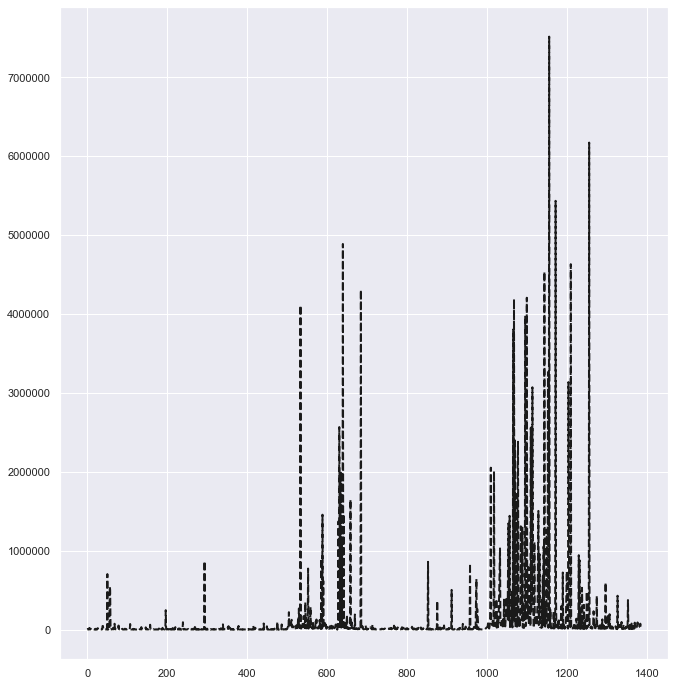

In [10]:
plt.subplot(1,2,1)
plt.plot(Data_f['Post Total Reach'].sort_index(), 'k--', linewidth=2)
#plt.axhline(y = Data_f['Post Total Reach'].mean(), color = 'k')
plt.plot(Data_f['Post organic reach'].sort_index(), 'r--')
#plt.axhline(y = Data_f['Post organic reach'].mean(), color = 'r')
plt.plot(Data_f['Post Paid Reach'].sort_index(), 'g--')
#plt.axhline(y = Data_f['Post Paid Reach'].mean(), color = 'g')
plt.title("Facebook Reach")
plt.legend(("Total", "Organic", "Paid"))

plt.subplot(1,2,2)
plt.plot(Data_f['Post Total Impressions'].sort_index(), 'k--', linewidth=2)
#plt.axhline(y = Data_f['Post Total Impressions'].mean(), color = 'k')
plt.plot(Data_f['Post Organic Impressions'].sort_index(), 'r--')
#plt.axhline(y = Data_f['Post Organic Impressions'].mean(), color = 'r')
plt.plot(Data_f['Post Paid Impressions'].sort_index(), 'g--')
#plt.axhline(y = Data_f['Post Paid Impressions'].mean(), color = 'g')
plt.title("Facebook Impressions")
plt.legend(("Total", "Organic", "Paid"))

plt.savefig(os.path.join(directory_img, "organic_paid.png"), bbox_inches='tight')

In [ ]:
plt.plot(Data_f['Post Total Reach'].sort_index(), 'k--')
plt.plot(Data_f['Post organic reach'].sort_index(), 'r')

## Fourth step of feature engineering
* Remove couples of features that are very similar and are highly correlated to reduce the dimension of the dataset
* Create 4 new variables corresponding to the number of times in which words from the 4 set of keywords has been used in a post
* Insert features related to the effectiveness of the paid: paid/organic. If organic == 0 then effectiveness = 0 if paid == 0 1 otherwise

In [8]:
"""Data to be removed cause highly correlated to Engaged Users"""
Data_f.drop('Matched Audience Targeting Consumers on Post', axis = 1, inplace = True) 
Data_f.drop('Matched Audience Targeting Consumptions on Post', axis = 1, inplace = True) 
Data_f.drop('Matched Audience Targeting Consumptions by Type - other clicks', axis = 1, inplace = True)
Data_f.drop('Post Audience Targeting Unique Consumptions by Type - other clicks', axis = 1, inplace = True)

"""Data to be removed cause highly correlated to Negative Feedback"""
Data_f.drop('Negative Feedback by Type - hide_all_clicks', axis = 1, inplace = True) 
Data_f.drop('Negative Feedback by Type - hide_clicks', axis = 1, inplace = True) 
Data_f.drop('Negative Feedback from Users', axis = 1, inplace = True) 
Data_f.drop('Negative Feedback from Users by Type - hide_all_clicks', axis = 1, inplace = True) 
Data_f.drop('Negative Feedback from Users by Type - hide_clicks', axis = 1, inplace = True)

"""Data to be removed cause highly correlated to Post Total Reach"""
Data_f.drop('Post Total Impressions', axis = 1, inplace = True)
Data_f.drop('Post organic reach', axis = 1, inplace = True)
Data_f.drop('Post Organic Impressions', axis = 1, inplace = True)
Data_f.drop('Organic Video Views', axis = 1, inplace = True)
Data_f.drop('Organic Video Views.1', axis = 1, inplace = True)

"""Data to be removed cause highly correlated to Post Paid Reach"""
Data_f.drop('Post Paid Impressions', axis = 1, inplace = True)
Data_f.drop('Post Paid Impressions by people who have liked your Page', axis = 1, inplace = True)
Data_f.drop('Paid Video Views.1', axis = 1, inplace = True)
Data_f.drop('Paid Video Views', axis = 1, inplace = True)
Data_f.drop('Paid reach of a post by people who like your Page', axis = 1, inplace = True)

"""Data to be removed cause highly correlated to other features"""
Data_f.drop('Organic views to 95%.1', axis = 1, inplace = True) # we keep "Organic views to 95%"
Data_f.drop('Paid views to 95%.1', axis = 1, inplace = True) # we keep "Paid views to 95%"

Data_f.drop('Post Stories by action type - share', axis = 1, inplace = True)
# we keep "Talking About This (Post) by action type - share"
Data_f.drop('Post Stories by action type - like', axis = 1, inplace = True)
# we keep "Talking About This (Post) by action type - like"
Data_f.drop('Post Stories by action type - comment', axis = 1, inplace = True)
# we keep "Talking About This (Post) by action type - comment"

Data_f.drop('Matched Audience Targeting Consumptions by Type - link clicks', axis = 1, inplace = True)
# we keep "Post Audience Targeting Unique Consumptions by Type - link clicks"
Data_f.drop('Matched Audience Targeting Consumptions by Type - photo view', axis = 1, inplace = True)
# we keep "Post Audience Targeting Unique Consumptions by Type - photo view"
Data_f.drop('Matched Audience Targeting Consumptions by Type - video play', axis = 1, inplace = True)
# we keep "Post Audience Targeting Unique Consumptions by Type - video play"


From this correlation matrix we understand that few features explain entire sets of features (corr >= 0.97.
#### Engaged Users explains:
* Matched Audience Targeting Consumers on Post
* Matched Audience Targeting Consumptions on Post
* Matched Audience Targeting Consumptions by Type - other clicks

#### Negative Feedback explains:
* Negative Feedback by Type - hide_all_clicks
* Negative Feedback by Type - hide_clicks
* Negative Feedback from Users
* Negative Feedback from Users by Type - hide_clicks
* Negative Feedback from Users by Type - hide_all_clicks

#### Post Total Reach explains:
* Post Total Impressions
* Post organic reach
* Post Organic Impressions
* Organic Video Views
* Organic Video Views.1

#### Post Paid Reach explains:
* Post Paid Impressions
* Post Paid Impressions by people who have liked your Page
* Paid Video Views
* Paid Video Views.1
* Paid reach of a post by people who like your Page

Furthermore we notice that:
* Matched Audience Targeting Consumptions are correlated with Post Audience Targeting Unique Consumptions for all types
* Post Stories are correlated with Talking About This (Post) for all actions 

In [9]:
def paid_efficacity(org, paid):
    if org != 0:
        return paid/org
    return float(paid > 0)

#in french it's 'Message de publication'
Data_f.drop('Post Message', axis = 1, inplace = True)

#Data_f['Paid views to 95% eff'] = Data_f['Organic views to 95%'].apply(paid_efficacity, paid = Data_f['Paid views to 95%'])
#Data_f['Paid Video Views eff'] = Data_f['Organic Video Views'].apply(paid_efficacity, paid = Data_f['Paid Video Views'])

Q4 = Data_f[Data_f['Type_Video'] == 1].corr()
Q5 = Data_f[Data_f['Type_Video'] == 0].corr()
Q6 = Data_f.corr()

plt.subplot(1,3,1)
sns.heatmap(Q4, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = True)

# we move this one to the right since it's different from the previous ones in terms of dimension
plt.subplot(1,3,3)
sns.heatmap(Q5, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

plt.subplot(1,3,2)
sns.heatmap(Q6, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

plt.savefig(os.path.join(directory_img, "corr_comparison_after.png"))
plt.close()

pict_reduced_html = 'reduced_corr.html'
Html_file = open(os.path.join(directory_img, pict_reduced_html),"w")
Html_file.write(Q6.style.background_gradient(cmap='coolwarm').render())
Html_file.close

<function TextIOWrapper.close()>

## RMK
It seems like if the paid was the most important component of the Reach.
In other words, the easy way to bost a post for both its reach and impressions is by paying since that's what makes the difference

Now we will try to further analyse this concept with an example on the Reach and on the impressions

In [11]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return [m-h, m, m+h]

def intersection_confidence_interval(int_1, int_2):
    new_min = max(int_1[0],int_2[0])
    new_max = min(int_1[2],int_2[2])
    return [new_min, new_max]

def test_same_mean(data_1, data_2, confidence=0.95):
    int_1 = mean_confidence_interval(data_1, confidence=confidence)
    int_2 = mean_confidence_interval(data_2, confidence=confidence)
    new_int = intersection_confidence_interval(int_1, int_2)
    return new_int[0] < new_int[1]

<function TextIOWrapper.close()>

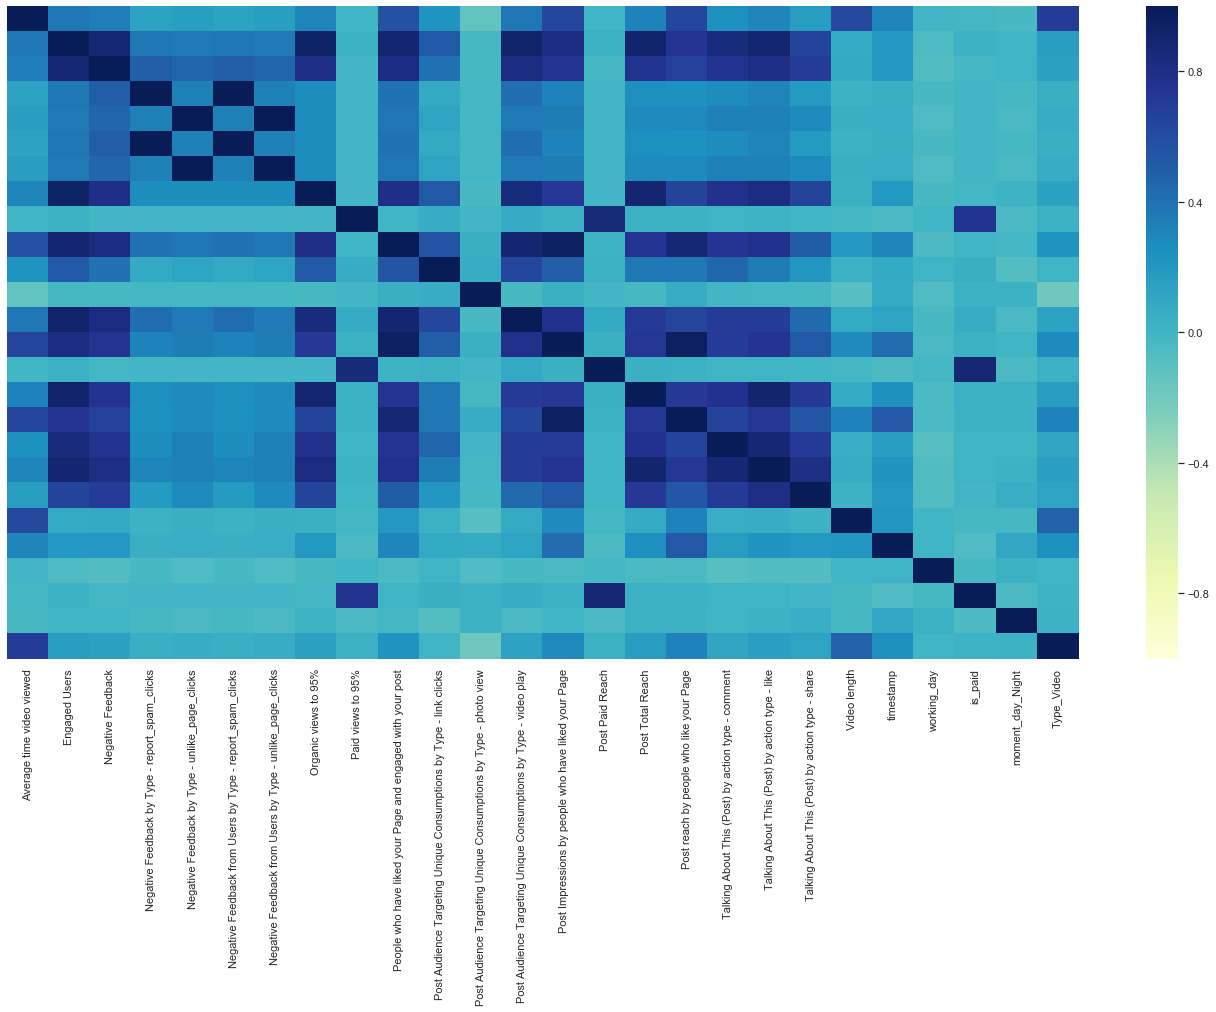

In [12]:
Q_time = Data_f.corr()

sns.heatmap(Q_time, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

plt.savefig(os.path.join(directory_img, "corr_time_blue.png"))

pict_reduced_html = 'corr_time.html'
Html_file= open(os.path.join(directory_img, pict_reduced_html),"w")
Html_file.write(Q_time.style.background_gradient(cmap='coolwarm').render())
Html_file.close

In the next cells we are going to study some confidence intervals in order to find some significant difference between the data. Before doing that we need to check the gaussianity of our data and in case this hypothesis is not respected we need to understand why.

## KPI for the matrices
This short session is about obtaining the KPI for the Renault matrix

In [13]:
# function that extract from a dataset only the elements between two dates
def campaign_selection(dataset, first_day, last_day):
    first_timestamp = datetime.timestamp(datetime.strptime(first_day, '%m/%d/%Y %I:%M:%S %p'))
    last_timestamp = datetime.timestamp(datetime.strptime(last_day, '%m/%d/%Y %I:%M:%S %p'))
    res = dataset[(dataset['timestamp'] >= first_timestamp) & (dataset['timestamp'] <= last_timestamp)].copy()
    return res

def KPI_dict_FB(data, with_marge, confidence = 0.95):
    index_IC = 1
    if with_marge:
        index_IC = 0
    dict_FB = {
       'Total post': data.shape[0],
        'Total video': sum(data['Type_Video'] == 1),
        'Video/post': sum(data['Type_Video'] == 1) / data.shape[0],
        'Average total reach / post': mean_confidence_interval(data['Post Total Reach'],
                                                        confidence = confidence)[index_IC],
        'Average organic reach / post': mean_confidence_interval(data['Post organic reach'],
                                                        confidence = confidence)[index_IC],
        'Average video total reach / post': mean_confidence_interval(data[data['Type_Video'] == 1]['Post Total Reach'],
                                                        confidence = confidence)[index_IC],
        'Average video organic reach / post': mean_confidence_interval(data[data['Type_Video'] == 1]['Post organic reach'],
                                                        confidence = confidence)[index_IC],
        'Organic Video Views / post': mean_confidence_interval(data[data['Type_Video'] == 1]['Organic Video Views'],
                                                               confidence = confidence)[index_IC],
        'Paid Video Views / post': mean_confidence_interval(data[data['Type_Video'] == 1]['Paid Video Views'],
                                                               confidence = confidence)[index_IC],
        'Videos Average views (>=30s)': sum((data['Type_Video'] == 1) & (data['Average time video viewed'] >= 30))/
            sum(data['Type_Video'] == 1),
        'Average share / post': mean_confidence_interval(data['Talking About This (Post) by action type - share'],
                                                        confidence = confidence)[index_IC],
        'Average like / post': mean_confidence_interval(data['Talking About This (Post) by action type - like'],
                                                       confidence = confidence)[index_IC],
        'Average comment / post': mean_confidence_interval(data['Talking About This (Post) by action type - comment'],
                                                          confidence = confidence)[index_IC],
        'Videos Average share / post':
         mean_confidence_interval(data[data['Type_Video'] == 1]['Talking About This (Post) by action type - share'],
                                 confidence = confidence)[index_IC],
        'Videos Average like / post':
        mean_confidence_interval(data[data['Type_Video'] == 1]['Talking About This (Post) by action type - like'],
                                confidence = confidence)[index_IC],
        'Videos Average comment / post':
        mean_confidence_interval(data[data['Type_Video'] == 1]['Talking About This (Post) by action type - comment'],
                                confidence = confidence)[index_IC],
        'Videos Average Completion (percentage)':mean_confidence_interval(
        data[data['Type_Video'] == 1]['Average time video viewed']/data[data['Type_Video'] == 1]['Video length'],
        confidence = confidence)[index_IC]*100
    }
    for k in dict_FB.keys():
        print(k, dict_FB[k])
    return dict_FB

tequila_data = campaign_selection(Data_f, '05/01/2019 01:00:00 AM', '12/31/2020 11:00:00 PM')
conf = 0.95
print('Organic')
KPI_dict_FB(tequila_data[tequila_data['is_paid'] == 0], with_marge = False, confidence = conf)
print('Paid')
KPI_dict_FB(tequila_data[tequila_data['is_paid'] == 1], with_marge = False, confidence = conf)
print('Done')


Organic


KeyError: 'Post organic reach'

In [14]:
from scipy.stats import shapiro
from scipy.stats import boxcox

W1,p1 = shapiro(Data_f)
Data_no_bool = Data_f.drop(['Type_Video', 'moment_day_Night', 'timestamp', 'working_day'], axis = 1)
W2,p2 = shapiro(Data_no_bool)
print("test1 W,p", W1, p1)
print("test2 W,p", W2, p2)

gauss_dict = dict.fromkeys(Data_no_bool.columns)
for col in Data_no_bool.columns:
    _, p_orig = shapiro(Data_f[col])
    col_min = min(Data_f[col])
    if col_min == 0.0:
        col_min = 1e-4
    # boxcox need positive data so we shift everything iff the column has negative value
    trasnformed_data, _ = boxcox(Data_f[col] + col_min)
    _, p_box = shapiro(trasnformed_data)
    gauss_dict[col] = [p_orig, p_box]
gauss_dict

test1 W,p 0.18871217966079712 0.0
test2 W,p 0.07454609870910645 0.0


C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\scipy\optimize\optimize.py:1975: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


{'Average time video viewed': [1.3213049939668157e-36, 3.2229864679470793e-44],
 'Engaged Users': [0.0, 1.6397472701277162e-20],
 'Negative Feedback': [0.0, 8.314589523771487e-35],
 'Negative Feedback by Type - report_spam_clicks': [0.0, 1.0],
 'Negative Feedback by Type - unlike_page_clicks': [0.0, 1.0],
 'Negative Feedback from Users by Type - report_spam_clicks': [0.0, 1.0],
 'Negative Feedback from Users by Type - unlike_page_clicks': [0.0, 1.0],
 'Organic views to 95%': [0.0, 1.9287511523531538e-36],
 'Paid views to 95%': [0.0, 1.0],
 'People who have liked your Page and engaged with your post': [0.0,
  1.1062394286742196e-15],
 'Post Audience Targeting Unique Consumptions by Type - link clicks': [0.0,
  4.189336462449502e-38],
 'Post Audience Targeting Unique Consumptions by Type - photo view': [0.0,
  1.401298464324817e-45],
 'Post Audience Targeting Unique Consumptions by Type - video play': [0.0,
  2.4308555394629522e-37],
 'Post Impressions by people who have liked your Page'

## The overall dataset is not gaussian as we could have expected since the ddata differs a lot in case we consider paid/organic, video/photo and these kind of differences. Now we are going to study the gaussianity of the subsets focusing only on the reach and on the impression that are our main goals of observation:

It can be useful to perform th eso called "permutation test" in order to deal with the lack of gaussianity

In [15]:
Data_no_bool_paid_video = Data_no_bool[(Data_no_bool['Post Paid Reach'] > 0) & (Data_no_bool['Average time video viewed'] > 0)]
[['Post Total Reach', 'Post organic reach', 'Post Paid Reach',
  'Post Total Impressions', 'Post Organic Impressions', 'Post Paid Impressions', 'Average time video viewed', 'Video length']]

Data_no_bool_org_video = Data_no_bool[(Data_no_bool['Post Paid Reach'] == 0) & (Data_no_bool['Average time video viewed'] > 0)]
[['Post Total Reach', 'Post organic reach', 'Post Paid Reach',
  'Post Total Impressions', 'Post Organic Impressions', 'Post Paid Impressions', 'Average time video viewed', 'Video length']]

Data_no_bool_paid_photo = Data_no_bool[(Data_no_bool['Post Paid Reach'] > 0) & (Data_no_bool['Average time video viewed'] == 0)]
[['Post Total Reach', 'Post organic reach', 'Post Paid Reach',
  'Post Total Impressions', 'Post Organic Impressions', 'Post Paid Impressions']]

Data_no_bool_org_photo = Data_no_bool[(Data_no_bool['Post Paid Reach'] == 0) & (Data_no_bool['Average time video viewed'] == 0)]
[['Post Total Reach', 'Post organic reach', 'Post Paid Reach',
  'Post Total Impressions', 'Post Organic Impressions', 'Post Paid Impressions']]

print('Data_no_bool_paid_video W,p', shapiro(Data_no_bool_paid_video))
print('Data_no_bool_org_video W,p', shapiro(Data_no_bool_org_video))
print('Data_no_bool_paid_photo W,p', shapiro(Data_no_bool_paid_photo))
print('Data_no_bool_org_photo W,p', shapiro(Data_no_bool_org_photo))

Data_no_bool_paid_video W,p (0.43382686376571655, 1.5632069274543366e-14)
Data_no_bool_org_video W,p (0.10100889205932617, 0.0)
Data_no_bool_paid_photo W,p (0.43356454372406006, 3.3085914452612997e-08)
Data_no_bool_org_photo W,p (0.2540072202682495, 0.0)


Even focusing only on some variables and constraining our attention to homogeneous groups of variables we still do not have gaussianity. As a result we can't use directly the CI of gaussian data =>.

In [16]:
print("Total Reach var by night", Data_f[(Data_f['moment_day_Night'] == 1)]['Post Total Reach'].std())
print("Total Reach var by morning", Data_f[(Data_f['moment_day_Night'] == 0)]['Post Total Reach'].std())

print("Total Reach IC by night", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 1)]['Post Total Reach'], 0.8))
print("Total Reach IC by morning", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 0)]['Post Total Reach'], 0.8))
print("Organic Reach IC by night", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 1) & (Data_f['Post Paid Reach'] == 0.0)]['Post Total Reach'], 0.9))
print("Paid Reach IC by night", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 1) & (Data_f['Post Paid Reach'] > 0.0)]['Post Total Reach'], 0.9))
print("Organic Reach IC by morning", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 0) & (Data_f['Post Paid Reach'] == 0.0)]['Post Total Reach'], 0.9))
print("Paid Reach IC by morning", mean_confidence_interval(
    Data_f[(Data_f['moment_day_Night'] == 0) & (Data_f['Post Paid Reach'] > 0.0)]['Post Total Reach'], 0.9))


Total Reach var by night 618963.7201095758
Total Reach var by morning 504346.12936869514
Total Reach IC by night [116578.2124491443, 153258.12793176973, 189938.0434143952]
Total Reach IC by morning [90424.56251747526, 112585.19953051643, 134745.8365435576]
Organic Reach IC by night [106153.17673098278, 153258.12793176973, 200363.07913255668]
Paid Reach IC by night [nan, nan, nan]
Organic Reach IC by morning [82429.2460081013, 110969.45047169812, 139509.65493529494]
Paid Reach IC by morning [133295.52704615908, 455124.0, 776952.4729538409]


C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\lfiorentini\anaconda3\envs\MachineLearning\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


* Unless we use a very permissive test (55%) we can't find any difference between night and morning on the total reach
* For the organic part we can see that posting by night is clearly better
* For the paid part there is not such a big difference

In [17]:
Paid_data = Data_f[Data_f['Post Paid Reach'] > 0]
Organic_data = Data_f[Data_f['Post Paid Reach'] == 0.0]
print("Paid_data['Post Total Reach'].mean() ", Paid_data['Post Total Reach'].mean())
print("Organic_data['Post Total Reach'].mean() ", Organic_data['Post Total Reach'].mean())
print("Paid_data['Post Total Impressions'].mean() ", Paid_data['Post Total Impressions'].mean())
print("Organic_data['Post Total Impressions'].mean() ", Organic_data['Post Total Impressions'].mean())

Q_paid = Paid_data.corr()
sns.heatmap(Q_paid, cmap="YlGnBu", vmin=-1, vmax=1, xticklabels = True, yticklabels = False)

pict_paid_html = 'paid_corr.html'
Html_file= open(os.path.join(directory_img, pict_paid_html),"w")
Html_file.write(Q_paid.style.background_gradient(cmap='coolwarm').render())
Html_file.close

Paid_data['Post Total Reach'].mean()  455124.0
Organic_data['Post Total Reach'].mean()  126028.97190584661


KeyError: 'Post Total Impressions'

## PCA analysis
performed after a min max scale

In [ ]:
scaler = MinMaxScaler().fit(Data_f)
Data_f_scaled = pd.DataFrame(scaler.transform(Data_f), columns = Data_f.columns)

Data_reduced_scaled = Data_f_scaled.drop(['timestamp', 'moment_day_Night', 'working_day', 
                                       'Type_Video', 'is_paid',
                                       'Organic views to 95%', 'Paid views to 95%', 'Organic Video Views',
                                       'Paid Video Views', 'Average time video viewed', 'Video length',
                                       'Talking About This (Post) by action type - share',
                                       'Talking About This (Post) by action type - like',
                                       'Talking About This (Post) by action type - comment',
                                       'Matched Audience Targeting Consumptions by Type - other clicks',
                                       'Negative Feedback by Type - hide_all_clicks',
                                       'Negative Feedback by Type - hide_clicks'], axis = 1)

#Data_reduced_scaled = Data_f_scaled.drop(['timestamp', 'moment_day_Night', 'is_tequila', 'working_day', 
#                                       'environment', 'mobility', 'city', 'models', 'Type_Video',
#                                       'Organic views to 95%', 'Paid views to 95%', 'Organic Video Views',
#                                       'Paid Video Views', 'Average time video viewed', 'Video length'], axis = 1)

#Data_reduced_scaled = Data_f_scaled.drop(['timestamp'], axis = 1)

Data_scaled_photo = Data_f_scaled[Data_f_scaled['Type_Video'] == 0].drop([
    'timestamp','moment_day_Night', 'working_day', 'Type_Video',
       'Organic views to 95%', 'Paid views to 95%', 'Organic Video Views', 'Paid Video Views', 'Average time video viewed',
       'Video length', 'Talking About This (Post) by action type - share', 'Talking About This (Post) by action type - like',
       'Talking About This (Post) by action type - comment', 'Matched Audience Targeting Consumptions by Type - other clicks',
       'Negative Feedback by Type - hide_all_clicks', 'Negative Feedback by Type - hide_clicks', 'is_paid'], axis = 1).copy()

Data_scaled_video = Data_f_scaled[Data_f_scaled['Type_Video'] == 1].drop([
    'timestamp', 'moment_day_Night', 'working_day', 'Type_Video',
      'Talking About This (Post) by action type - share', 'Talking About This (Post) by action type - like',
      'Talking About This (Post) by action type - comment', 'Matched Audience Targeting Consumptions by Type - other clicks',
      'Negative Feedback by Type - hide_all_clicks', 'Negative Feedback by Type - hide_clicks', 'is_paid'], axis = 1).copy()

precision = 0.90

pca_obj = PCA(precision)
pc_data = pca_obj.fit_transform(Data_reduced_scaled)
print(pca_obj.explained_variance_ratio_)

pca_load = pca_obj.components_
print(pca_load.shape)

sns.heatmap(pca_load, annot = True, center = 0, xticklabels = Data_reduced_scaled.columns, yticklabels = False)

If we perform the PCA on the data with the new features added we will see that the first 3 PC are mainly contrast vectors among the features Type_Video, moment_day_Night is_tequila and working_day.
Whereas, if we remove moment_day_Night is_tequila and working_day (that we have added to the original dataset) along with the example of frequencies of keywords, we get that the first 3 PC are a impression and reach from people who liked the page against or with the type of the video and impression by people who liked the page vs negative feedback.

Since Type_Video is actuall describing cathegories we can remove it and perform again PCA. The result is that the first PC is a weighted sum of impression and reach from people who liked the page while the second is the contrast between these features and the negative feedback. The last one is the contrast between paid and total reach/impressions v.s. the one due to people who liked the page.
Following this last analysis, we give the following names to the axis of the first 3 PC:
* performances on likers
* negative feedback - likers
* performances on non likers

This result can also be interpreted claiming that the behavior of likers and people who don't like the page are orthogonal.

If we also drop the features
* 'Talking About This (Post) by action type - share',
* 'Talking About This (Post) by action type - like',
* 'Talking About This (Post) by action type - comment',
* 'Matched Audience Targeting Consumptions by Type - other clicks',
* 'Negative Feedback by Type - hide_all_clicks',
* 'Negative Feedback by Type - hide_clicks'
we observe that the second PC has a more important component of the organic performances and engagement which means that organic performances, engagement and negative feedback are indipendent.

If we introduce the paid it will revolutionate the whole dataset becoming the most important feature

In [ ]:
pca_obj_photo = PCA(precision)
pc_data_photo = pca_obj_photo.fit_transform(Data_scaled_photo)
print(pca_obj_photo.explained_variance_ratio_)

pca_load_photo = pca_obj_photo.components_
print(pca_load_photo.shape)

sns.heatmap(pca_load_photo, annot = True, center = 0, xticklabels = Data_scaled_photo.columns, yticklabels = False)

For the photos the situation is quite different and the first 3 PC can be interpreted as
* Organic performances engagement, negative feedback, total performances on likers
* Organic performances and engagement vs total and paid
* All performances vs  paid performances on likers

The fact that the these PCA are quite different from the previous ones means that the data between videos and photos are different

In [ ]:
pca_obj_video = PCA(precision)
pc_data_video = pca_obj_video.fit_transform(Data_scaled_video)
print(pca_obj_video.explained_variance_ratio_)

pca_load_video = pca_obj_video.components_
print(pca_load_video.shape)

sns.heatmap(pca_load_video, annot = True, center = 0, xticklabels = Data_scaled_video.columns, yticklabels = False)

For the videos the situation is quite different and the first 3 PC can be interpreted as
* performances on likers
* Organic performances, engagement and negative feedback vs impressions on likers
* no clear meaning

This confirms that data between videos and photos are different

## 2 ways ANOVA using statsmodels
The purpose of this study is to use 2ways ANOVA  to understand which features play an important role in the definition of the role played by some categorical variables on the variable of bigger interest (Total Reach and Total Impressions)
In order to do this we will start with a complete model and then we will remove progressively the less important variables starting from interactions whenever possible.

Attention: we will consider only interactions up to the second level

In [ ]:
#We in order to use ANOVA we must have all the labels without spaces otherwise formulas won't work
Data_ANOVA = Data_f_scaled.copy()
new_list = []
for i in range(len(Data_ANOVA.columns)):
    new_list.append(Data_ANOVA.columns[i].replace(" ", "_"))

Data_ANOVA.columns = new_list

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

class Iterative_ANOVA():
    def __init__(self, data, y_lab, x_in_lab_list, thres = 0.01):
        self.data = data
        self.thres = thres
        self.y_lab = y_lab
        self.__x_lab_list__ = []
        for lab in x_in_lab_list:
            self.__x_lab_list__.append('C(' + lab + ')')
        self.__full_list__ = self.__x_lab_list__ + self.__create_inter__(self.__x_lab_list__)
        self.__curr_list__ = self.__full_list__
        self.p_values_history = {key : [] for key in self.__full_list__}
        self.history = []
        self.last_model = []
        
    def __create_inter__(self, __x_lab_list__):
        res = []
        for i in range(len(__x_lab_list__)-1):
            for j in range(i+1,len(__x_lab_list__)):
                res.append(__x_lab_list__[i] + ':' + __x_lab_list__[j])
        return res
    
    def __create_formula__(self):
        formula = self.y_lab + ' ~ '
        for lab in self.__curr_list__:
            formula = formula + lab + ' + '
        return formula[:-3]
    
    # function that remove the interaction terms of labels already used 
    def __remove_inter__(self, basic_label):
        to_remove = []
        for lab in self.__curr_list__:
            if basic_label in lab:
                to_remove.append(lab)
        
        for lab in to_remove:
            self.__curr_list__.remove(lab)
            
    def fit(self):
        max_p = 1
        max_lab = 'not_a_label'
        curr_anova = []
        n_iter = 0
        print("Starting ANOVA with:")
        print(self.__curr_list__)
        while max_p > self.thres:
            #remove feature and its interactions
            if max_lab in self.__curr_list__:
                    self.__remove_inter__(max_lab)
            
            #create new formula
            curr_formula = self.__create_formula__()
            
            #compute new ANOVA
            curr_anova = ols(curr_formula, data = self.data).fit()
            table = sm.stats.anova_lm(curr_anova, typ=2) # Type 2 ANOVA DataFrame
            max_lab = table['PR(>F)'].idxmax()
            max_p = table['PR(>F)'].max()
            print("ANOVA iter", n_iter)
            print(self.__curr_list__)
            print(max_lab)
            print(max_p)
            self.history.append(curr_anova)
            for lab in self.__full_list__:
                if lab in self.__curr_list__:
                    self.p_values_history[lab].append(table['PR(>F)'][lab])
                else:
                    self.p_values_history[lab].append(1)
        
            n_iter += 1
        
        self.last_model = curr_anova
        return curr_anova

    def get_curr_list(self):
        return self.__curr_list__
    
    def show_p_values_history(self):
        return p_values_history
    
    def summary():
        print(p_values_history)
        return self.last_model

In [ ]:
Reach_ANOVA = Iterative_ANOVA(Data_ANOVA, 'Post_Total_Reach',
                              #['Type_Video', 'is_tequila', 'is_paid', 'working_day', 'moment_day_Night'], 0.5)
                              ['Type_Video', 'working_day', 'moment_day_Night'], 0.01)
Reach_model = Reach_ANOVA.fit()
Reach_rel_cat = Reach_ANOVA.get_curr_list()

In [ ]:
sm.stats.anova_lm(Reach_ANOVA.history[5], typ=2)

In [ ]:
Impression_ANOVA = Iterative_ANOVA(Data_ANOVA, 'Post_Total_Impressions',
                              ['Type_Video', 'working_day', 'moment_day_Night'], 0.01)
Impression_model = Impression_ANOVA.fit()
Impression_rel_cat = Impression_ANOVA.get_curr_list()

If we use the is_paid variable we get numerical error due to the singularity of covariance matrices which means that some features are linear combinations of others. This is normal due to the lack of paid in a lot of moment. It is interesting to see that the only relevant variable is the difference between photos and videos.

## Linear regression

Now that we know which factors have an impact on the impressions and on the reach we can try to perform some linear regressions to be able to better quantify the relationship between the different features and the variables we want to predict

In [ ]:
print(Reach_rel_cat)
#LR_Reach =  ols(curr_formula, data = self.data).fit()
print(Data_ANOVA.columns)



Laura's notes:

in order to map content into vectors we can use the package "gensim". but we need a glossary of words and in order to do that we need an extractor which basically takes all the words without repetition removing the gender and all useless stuff....


## Clustering analysis
We try to find group of common posts using different algorithms
info about possible distances availables on https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score

def mean_intra_cluster_dist(clusters, distance = euclidean_distances):
    mean = 0
    n_clusters = clusters.shape[0]
    n_feat = clusters.shape[1]
    for i in range(n_clusters-1):
        for j in range(i+1,n_clusters):
            mean += distance(clusters[i,:].reshape(1, n_feat), clusters[j,:].reshape(1, n_feat))
    return float(mean/(n_clusters*(n_clusters-1)/2))

In [ ]:
min_clust = 2
max_clust = 10
n_clust_vec = range(min_clust, max_clust)
metric_str = 'euclidean'
# inertie silhouette 

# kmeans works well with n-dim balls
k_means_list = [];
k_means_results = [];
k_means_silhouettes = [];

fig = plt.figure(figsize=(20, 80))
for i in n_clust_vec:
    k_means_list.append(KMeans(n_clusters = i, random_state=0))
    k_means_results.append(k_means_list[i-min_clust].fit_predict(Data_reduced_scaled))
    k_means_silhouettes.append(silhouette_score(Data_reduced_scaled, k_means_results[i-min_clust], metric = metric_str))
    ax = fig.add_subplot(max_clust-min_clust, 1, i -min_clust + 1, projection='3d')
    ax.scatter(pc_data[:,0], pc_data[:,1], pc_data[:,2], c = k_means_results[i-min_clust], cmap='viridis', marker='o')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    fig.savefig(os.path.join(directory_img,"k_m_cluster_{}.png".format(i)))
    plt.close()
    
print(k_means_silhouettes)

# DBSCAN works well with more complex shapes based on density
# find avg distance inter and intra cluster
#DBSCAN_0 = DBSCAN().fit_predict(Data_scaled)
#DBSCAN_1 = DBSCAN().fit_predict(Data_scaled)
#DBSCAN_2 = DBSCAN().fit_predict(Data_scaled)

# SpectralClustering works well with more complex shapes based on density
#SpectralClustering_0 = SpectralClustering().fit_predict(Data_scaled)
#SpectralClustering_1 = SpectralClustering().fit_predict(Data_scaled)
#SpectralClustering_2 = SpectralClustering().fit_predict(Data_scaled)

score_lst = []
#score_lst.append(silhouette_score(Data_scaled, kmeans_0, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, kmeans_1, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, kmeans_2, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, DBSCAN_0, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, DBSCAN_1, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, DBSCAN_2, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, SpectralClustering_0, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, SpectralClustering_1, metric = metric_str) )
#score_lst.append(silhouette_score(Data_scaled, SpectralClustering_2, metric = metric_str) )

print(score_lst)

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

for i in n_clust_vec:
    fig = plt.figure(figsize=(20, 40))
    model = SilhouetteVisualizer(KMeans(i, random_state=0))
    model.fit(Data_reduced_scaled)
    model.show()    
    fig.savefig(os.path.join(directory_img, "k_m_silhouettes_{}.png".format(i) ))
    plt.close()

these graphs show us that no k-means is ideal, the best one is with k = 2. Increasing k with are forcing the algorithm to find clusters that do not exist in reality.
Silhouette close to 0 means that the algorithm is either completely wrong or the parameters are not working.
The negative we see points out that the data should go in another cluster but increasing the number of cluster doesn't solve this and even create too small clusters. What we should do is to study how to create similarities or to remove features in order to work only with easier data. 

## TSNE (Alternative to the PCA)
Another interesting method for dimensionality reduction and data visualization is the TSNE whose approach is explained at https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

Data_TSNE_2 = TSNE(n_components=2).fit_transform(Data_reduced_scaled)
Data_TSNE_3 = TSNE(n_components=3).fit_transform(Data_reduced_scaled)

fig = plt.figure(figsize=(20, 40))
Data_Video = Data_f[Data_f['Type_Video'] == 1]
ax = fig.add_subplot(2, 1, 1)
ax.scatter(Data_TSNE_3[:,0], Data_TSNE_3[:,1], c = k_means_results[0], cmap='viridis', marker='o', s = 30)
ax.set_xlabel('TSNE_2 1')
ax.set_ylabel('TSNE_2 2')

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.scatter(Data_TSNE_3[:,0], Data_TSNE_3[:,1], Data_TSNE_3[:,2], c = k_means_results[0], cmap='viridis', marker='o', s = 30)
ax.set_xlabel('TSNE_3 1')
ax.set_ylabel('TSNE_3 2')
ax.set_zlabel('TSNE_3 3')

fig.savefig(os.path.join(directory_img, "tsne.png"))

In [ ]:
Data4['Posted']

With the current set of parameters we are not able to find a clear clusterisation of the elements. For this reason the TSNE won't be considered in the future.